# SMS CORPUS ANALYSIS

The following is a study in using NLP libraries with Singapore SMS data.
<br>The sms data is provided by NUS on Kaggle. Due to the unstructured form of words and the fact that the data was obtained from SMS, there are multiple brickwalls to analysing the data.

Issues with sms data:
1. Singlish is prevalent in sms data and this prevent simple tokenization
2. Words were usually shortformed and mispelled
3. Multiple languages can be found in singlish
4. Multiple weird symbols can be found through out sentences


In navigating the issues we will proceed the analysis in the following sequence:
1. Download of file from kaggle with Kaggle api
2. Preprocess json data into q table
3. Use exploratory NLP libraries as provided by kx, the underlying library is spacy which has multiple dependencies
4. Through spacy, tokenization and stop words are used to simplify words2vec
5. Word2Vec was constructed from the token and skipgram was performed to obtain the cosine distance/similarity matrix of each word
6. Analysis was performed in looking up similarity of words against human perception and applying tsne to map similar words in a 2 dimensional space
7. Affinity propagation was applied to find clusters so that we can cross reference the results of tsne
8. Through the found clusters we can apply a categorical predictor on sentences instead of words
9. Conclusion

In [2]:
\c 200 200
//load nlp library from QHOME
//Library from https://github.com/awilson-kx/nlp.git
system "l ",getenv[`QHOME],"/nlp/init.q"

Loading utils.q
Loading regex.q
Loading sent.q
Loading parser.q
Loading time.q
Loading date.q
Loading email.q
Loading cluster.q
Loading nlp.q


In [174]:
//Import python libraries
wordCloud:.p.import[`wordcloud;`:WordCloud]
plt:.p.import[`matplotlib;`:pyplot]
np:.p.import[`numpy]
pd:.p.import[`pandas]
seaborn:.p.import[`seaborn]

## Kaggle Download Functionality

We use kaggle's api to download dataset from their public database easily

In this section we declare a wrapper around the kaggle api to allow more control over repeated downloads and where to place the data

In [4]:
/
Kaggle download functionality
Use instruction 
@dataStore: folder to store data
@kaggleUrl: kaggleUrl/folder for the kaggle API to download the files
- function uses this as the folder storage, if folder is missing, creates in current directory and proceed with downaload
\


.kaggle.downloadFile:{[dateStore;kaggleUrl] 
    kaggle:.p.import[`kaggle][`:api];
    //kaggle[`:dataset_download_cli][`$"";`path pykw system["cd"],"\\smsData"]
    -1"Check if ",1_string[dataStore]," exists?";
    $[()~key[dataStore];
        [-1"File is missing, initialise download";
        kaggle[`:dataset_download_cli][`$kaggleUrl;`path pykw system["pwd"],"/",1_string dataStore];
        /0N! 1_string fileDir;
        -1"\nDownload Complete!";];
        -1"File is present, skip download"
        ];
    }


In [5]:
//if statement needed to decide to load from hdb, kaggle then json
kaggleUrl:"rtatman/the-national-university-of-singapore-sms-corpus"
dataStore:`:smsData_Unprocessed
dataStoreProcess:`:smsData
$[`hdb in key dataStoreProcess;
    -1"HDB found, skipping kaggle download and processing of data";
    [-1"HDB not found, starting kaggle download";
        .kaggle.downloadFile[dataStore;kaggleUrl];
    ]
 ];


HDB found, skipping kaggle download and processing of data


## Loading SMS Json Data

In [6]:
// peek into folder and pick up json files
key[dataStore]
smsDataJsons:smsDataJsons where (smsDataJsons:` sv' dataStore,/:key[dataStore]) like "*.json"
smsDataJsons

`smsCorpus_en_2015.03.09_all.json`smsCorpus_zh_2015.03.09.json


`:smsData_Unprocessed/smsCorpus_en_2015.03.09_all.json`:smsData_Unprocessed/smsCorpus_zh_2015.03.09.json


In [7]:
smsDataQ:.j.k (raze read0 smsDataJsons[0])

In [8]:
//.Q.id is needed to remove @ from column names
5#smsDataExtracted:.Q.id smsDataQ[`smsCorpus][`message]

id    text                                                                                                                                                  source                                   ..
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..
10120 (,`$)!,"Bugis oso near wat..."                                                                                                                        `srcNumber`phoneModel`userProfile!((,`$)!..
10121 (,`$)!,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."                              `srcNumber`phoneModel`userProfile!((,`$)!..
10122 (,`$)!,"I dunno until when... Lets go learn pilates..."                                                                                               `srcNumber`phoneModel`userProfile!((,`$)!..


In [9]:
//example of sms data
//mainly nested in q dictionaries
//need to recursive raze to clean up nesting in text
//save 
@[first[smsDataExtracted];`text;raze]

id              | 10120f
text            | "Bugis oso near wat..."
source          | `srcNumber`phoneModel`userProfile!((,`$)!,51f;`@manufactuer`@smartphone!("unknown";"unknown");`userID`age`gender`nativeSpeaker`country`city`experience`frequency`inputMethod!+(,`$)..
destination     | `@country`destNumber!("unknown";(,`$)!,"unknown")
messageProfile  | `@language`@time`@type!("en";"unknown";"unknown")
collectionMethod| `@collector`@method`@time!("howyijue";"unknown";"2003/4")


## Preprocess data for all text messages

In [10]:
5?smsDataCleaned:select id, (raze value @)each text from smsDataExtracted

id    text                                                                                                                       
---------------------------------------------------------------------------------------------------------------------------------
17416 "Ooo you read? Haha thanks man. I will."                                                                                   
15600 "okok, need to go for class now. msg you later."                                                                           
5766  "Tick, tick, tick ..."                                                                                                     
19593 "Nope....you outside?"                                                                                                     
37671 "I'm asking Chester and ryan coz vivien say cannot I think! They dunhave to come for the dinner right! I'll let them know?"


In [11]:
//With kdb nlp library we are able to apply functions written in q on our text
//Spacy will run on each text list and return tokenized text and its base forms (lemmas) along with other useful points for nlp libarary

parser:.nlp.newParser[`en;`text`tokens`lemmas`pennPOS`isStop`sentChars`starts`sentIndices`keywords] 
$[`hdb in key dataStoreProcess;
    [-1"HDB found, skipping corpus creation and loading from hdb";
        system "l ",(1_string dataStoreProcess),"/hdb";
        sym:get ` sv dataStoreProcess,`sym;
        -1"Loaded HDB\n";
        show -5?hdb;
        corpus:hdb;
    ];
    [-1"HDB not found, starting corpus creation";
        corpus:parser smsDataCleaned`text;
        //save data to avoid creating corpus again
        (` sv dataStoreProcess;`hdb;`) set corpus:.Q.en[dataStoreProcess] corpus
    ]
 ];


HDB found, skipping corpus creation and loading from hdb
Loaded HDB

text                                                                                                                                         tokens                                                  ..
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..
"Maybe  <#>"                                                                                                                                 `sym$,`maybe                                            ..
"Lol don't need to be free to celebrate. So your javascript how?"                                                                            `sym$`lol`do`n't`need`to`be`free`to`celebrate`so`your`ja..
"Good FRIENDS CaRE for each Other.. CLoSE Friends UNDERSTaND each Other... and TRUE Friends STaY forever beyond words, beyond time.

In [12]:
//example of the product after corpus is ran on this
flip 1?select from corpus

text       | "Headed back"       
tokens     | headed back         
lemmas     | head back           
pennPOS    | VBN RB              
isStop     | 01b                 
sentChars  | 0 11                
starts     | 0 7                 
sentIndices| 0                   
keywords   | (,`headed)!,8.157281


## Exploratory visualisation
After we have preprocess our data into corpus, lets have a quick exploratory visualisation along with some simple insights

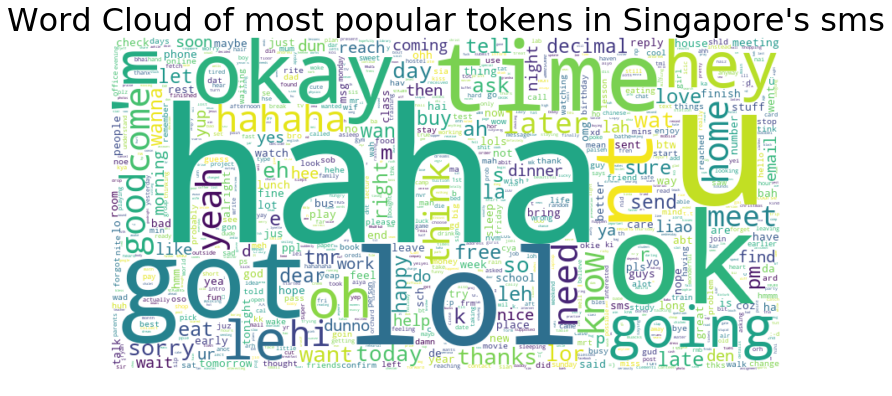

In [13]:
wc:wordCloud[pykwargs `background_color`max_words`width`height!(`white;1000;800;400)];
// Generate word frequency dictionary
n:count each gt:group text:value raze corpus[`tokens]@'where each not corpus`isStop
// push dictionary into WC library
wc[`:generate_from_frequencies][n];
plt[`:figure][`figsize pykw (12;9)];
plt[`:imshow][wc;`interpolation pykw `bilinear];
plt[`:axis][`off];
plt[`:title]["Word Cloud of most popular tokens in Singapore's sms";`fontsize pykw 32];
plt[`:show][];

In [14]:
// Use of nlp function TFIDF which quickly score importances of word in collection of separate documents 
{-1"Loading TFIDF for each random sms sent\n";show x;-1"\n"} each 4?.nlp.TFIDF corpus;

Loading TFIDF for each random sms sent

eh    | 3.864494
bigger| 8.290848
better| 5.143593


Loading TFIDF for each random sms sent

b      | 5.290339
minus  | 9.138289
sama   | 15.7812
nt     | 3.374639
laugh  | 7.433057
u      | 2.248721
jus    | 5.137403
super  | 5.852113
funni  | 10.23697
pattern| 9.138289


Loading TFIDF for each random sms sent

kisses| 6.886084
yei   | 10.59133


Loading TFIDF for each random sms sent

ah | 4.009432
hee| 4.430636




In [15]:
/.nlp.findRelatedTerms[corpus;"got"]


## Vectorization / Embedding
Despite the exploratory findings that shows the popular words, we do not know the similarity and how are the words related.
<br> Hence we need to vectorize the sentences into bag of similar words. With the group of words we will use gensim to perform a skip gram prediction model which seeks to predict the context given a word input
> Example: Delightful -> Yesterday was really
<br>



In [16]:
//skip gram is can be performed easily with gensim 
w2v:.p.import[`gensim;`:models;`:word2vec]

In [17]:
tokenizedCorpus:value each corpus`tokens
featureSize:max count each tokenizedCorpus
windowContext:3
minWordCount:1
sample:1e-3
-1"Start of Word2Vec model training";
w2vModel:w2v[`:Word2Vec][tokenizedCorpus;pykwargs `size`window`min_count`sample`iter!(featureSize;windowContext;minWordCount;sample;100)];
-1"End of Word2Vec model training";

Start of Word2Vec model training
End of Word2Vec model training


In [18]:
//Extracting the results from trained Word2Vec Model
-1"Each word label\n";
show 4#words:w2vModel[`:wv;`:index2word]`;
-1"\nEach word's vectorised cosine distance\n";
show 4?wvs:(w2vModel[`:wv;`:word_vec;<] each words);
w2vDictionary:$[`;words]!wvs;

Each word label

,"i"
"to"
,"u"
"you"

Each word's vectorised cosine distance

0.003023191 0.4267247  1.127551    -0.2467982  0.1651026  0.4760743  -0.312426    1.093627     -0.7314371  1.411473    -0.7556636  0.9796917    1.046888     0.9247019  -0.2121899   0.3296721  -0.81..
0.3767774   0.5052754  -0.2993194  -0.09631752 0.107456   -1.107912  -0.6208584   -0.7015151   -0.05729729 1.227522    0.03707401  -0.2010164   0.1025089    -0.4199637 0.1967936    0.1300922  -0.26..
0.1234853   0.08802484 -0.08108865 0.2299981   0.03139858 0.01467791 -0.08758671  -0.002480878 0.09862319  -0.1632438  -0.3977997  0.3308856    -0.004099893 -0.3362767 -0.003371183 0.04036684 0.353..
-0.084052   0.1307644  -0.1375609  0.2020495   0.02112655 -0.1301964 -0.004946542 0.09414963   -0.3599765  -0.02263286 0.001281215 0.0009473658 0.1840021    0.0153041  0.3561688    -0.1324837 -0.10..


## Cluster Visualisation 
With the trained word2vec model, we are able to use TSNE plot to compress the cosine distance into a 2d plot retaining as much information in the vector.
<br>This is also simply done with TSNE library from sklearn

In [201]:
//import library
TSNE:.p.import[`sklearn.manifold;`:TSNE];
//model Design with 5000 iteration and this is computationally expensive
tsneModel:TSNE[pykwargs`n_components`random_state`n_iter`perplexity`verbose!(2 0 5000 15 2)]
//np[`set_printoptions][`suppress pykw 1b]
timeNow:.z.T;
fitTSNE:tsneModel[`:fit_transform]np[`:array][wvs]
-1"Fitting of TSNE Model took: ",string .z.T-timeNow;

[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 36343 samples in 0.764s...
[t-SNE] Computed neighbors for 36343 samples in 1223.137s...
[t-SNE] Computed conditional probabilities for sample 1000 / 36343
[t-SNE] Computed conditional probabilities for sample 2000 / 36343
[t-SNE] Computed conditional probabilities for sample 3000 / 36343
[t-SNE] Computed conditional probabilities for sample 4000 / 36343
[t-SNE] Computed conditional probabilities for sample 5000 / 36343
[t-SNE] Computed conditional probabilities for sample 6000 / 36343
[t-SNE] Computed conditional probabilities for sample 7000 / 36343
[t-SNE] Computed conditional probabilities for sample 8000 / 36343
[t-SNE] Computed conditional probabilities for sample 9000 / 36343
[t-SNE] Computed conditional probabilities for sample 10000 / 36343
[t-SNE] Computed conditional probabilities for sample 11000 / 36343
[t-SNE] Computed conditional probabilities for sample 12000 / 36343
[t-SNE] Computed conditional probabilities for 

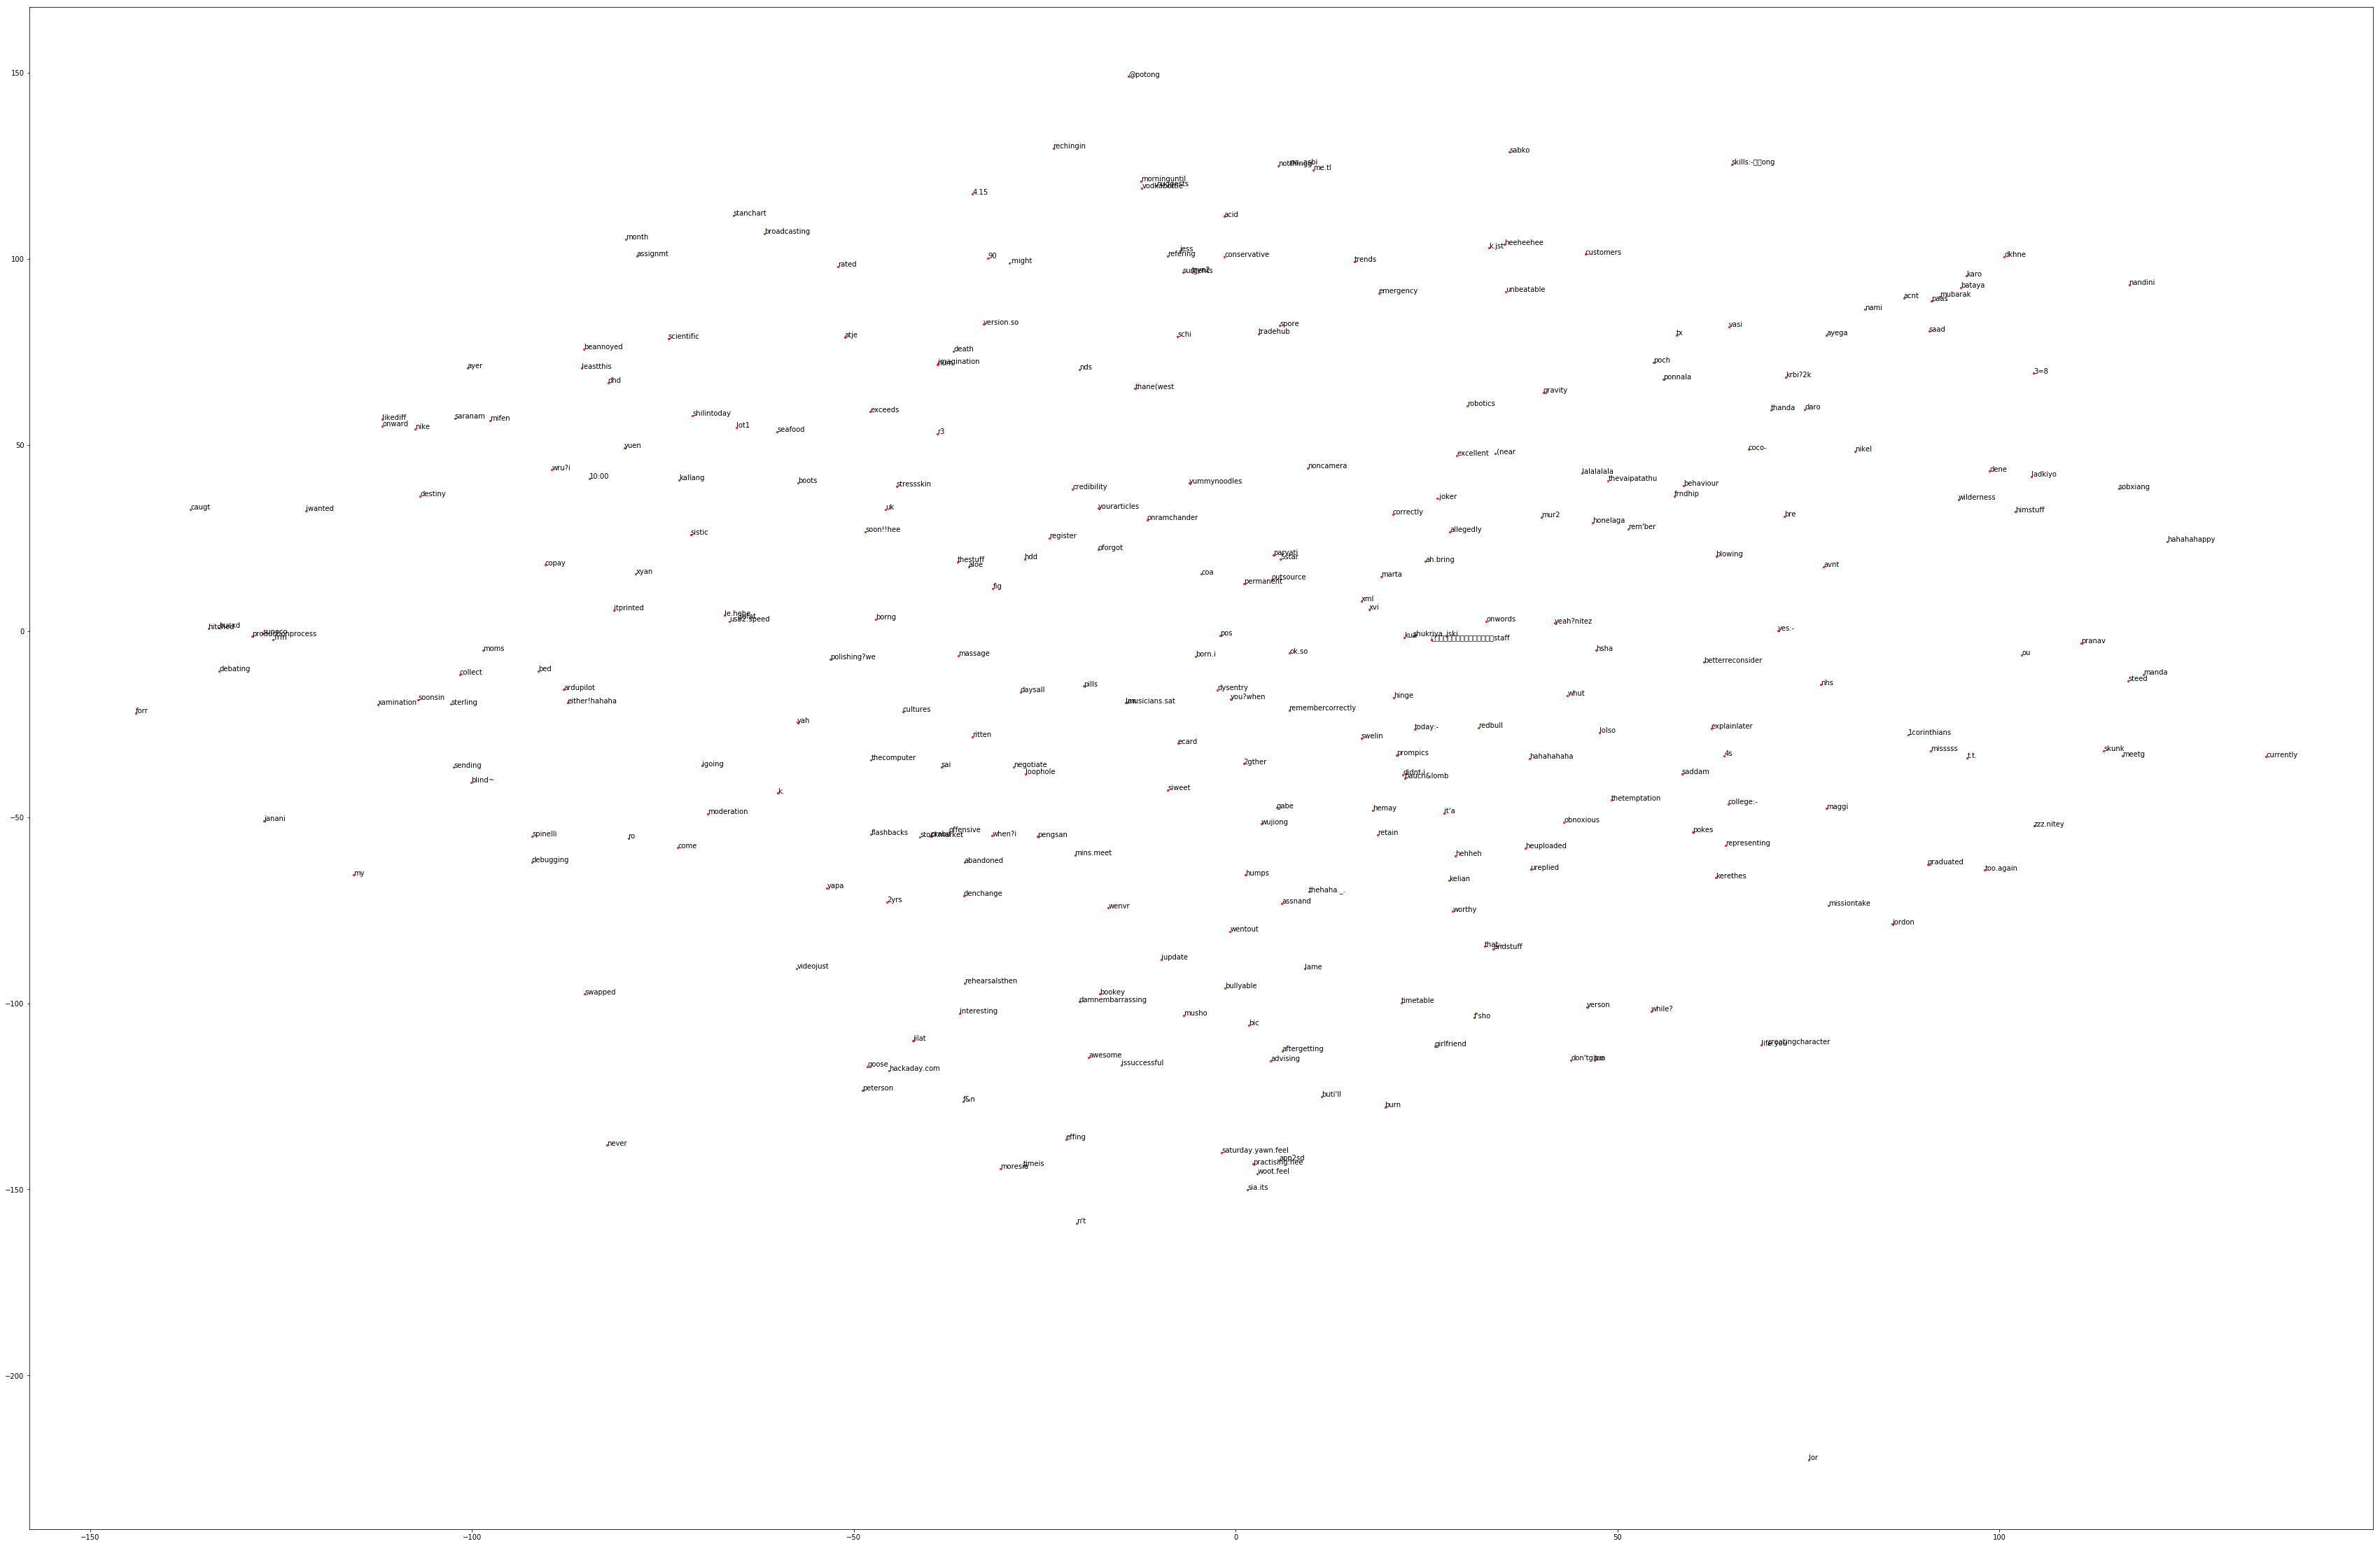

In [202]:
// After tsneModel has been fitted, we will plot the findings on a 2d space - toDo
sampleSize:-300
qfitTSNE:sampleSize?,'[`$words;fitTSNE`];

plt[`:figure][`figsize pykw (60 40)];
plt[`:scatter][qfitTSNE[;1];qfitTSNE[;2];pykwargs `c`edgecolors`s!(`orange;`r;4)];
//for loop for labels
//cluster word by colour then plot, dont need labels, spoils the graph
{.[plt[`:annotate];(x;pykwargs `xy`xytext`textcoords!((y;z);(0 0);"offset points"));{-2"Error due to: ",.Q.s x}]}.'qfitTSNE;
plt[`:show][];


An attempt to project the stochastic similarity of words using T-SNE (t-distributed stochastic neighbour embedding) did not provide much insight as the points are randomly clustered by the algorithm and the excessive words to cluster prevent us from reading the group of words.
<br>This shows the inadequacy of visualisation for word embedding currently but it was still an interesting concept
<br>A branch from the concept led us to us pre-clustering methods and we apply to the TSNE words to see if colors actually congregate together and this would prove that hte embedding of neighbour is sufficient

## Similarity Findings/Sms Nauces
From the cluster visualisation, we can run some similarity queries or prediction on our w2v trained model
Due to singlish and shorthands/unique words in sms data, we are able to see contrasting results between similar words such as msg and hunger.
<br>
1. For msg, the results return messages and text which made sense.
2. However for hunger, the results returned facebookkkkk which made no sense.
<br>

Possible contribution to this occurrence is explained in the uniqueness of SMS (short messages) and this requires sufficient cleansing preprocessing to produce more accurate results.

In [23]:
-1"Examples of similar words with msg\n";
show 3#w2vModel[`:wv][`:similar_by_word][`msg]`;
-1"\n Examples of similar words with hunger\n";
show 3#w2vModel[`:wv][`:similar_by_word][`hunger]`;

Examples of similar words with msg

"sms"     0.5765985
"message" 0.4985268
"text"    0.4339687

 Examples of similar words with hunger

"facebookkkk" 0.7536917
"shyness"     0.7483267
"currentones" 0.745221 


## Affinity clustering

Given that Word2Vec is an unsupervised learning model, it will be appreciated if we are able to cluster the words and this will provide an additional dimension of understanding toward all the words.
<br>

Ideally we would like to cluster sentences into specific category and this will allow us to sort sms sentences by the topic category with this simple affinity cluster
<br>

An option to clustering of the sentences is to obtain the document level embedding from each of the words. Following which, averaging can be adopted and affinity cluster can be performed on this

In [81]:
//Preparing each sentence feature vector
2#affinityClusterVector:{raze (sum w2vDictionary value x)%count x}each corpus[`tokens]
//cleaning up the nulls
locat:where affinityClusterVector~\:();
affinityClusterVector:@[affinityClusterVector;locat;:;count[locat]#enlist (count first affinityClusterVector)#0]
pyAffinityClusterVector:np[`:array]5000#affinityClusterVector

0.009160593 -0.4860418 0.1264063  -0.5454342 -0.2941033 1.097711    0.02934937 -0.5550291 1.23009   -0.2535363 0.5345309 0.4309152    -1.989769 1.397572  -0.2861267 0.1637003 -0.1704349 -0.7910138 ..
-0.1856377  -0.1048273 -0.4296007 0.2493492  -0.2886276 -0.02567683 0.1803198  0.5220685  0.7569907 0.0872762  0.9341994 -0.006780267 -1.014953 0.6748857 -0.3505778 0.3215439 0.2674988  0.0428386  ..


In [82]:
print pd[`:DataFrame]pyAffinityClusterVector

           0         1         2      ...          176       177       178
0     0.009161 -0.486042  0.126406    ...     0.088143 -0.155231  0.153297
1    -0.185638 -0.104827 -0.429601    ...     0.518355 -0.378400  0.454249
2    -0.277035  0.071660  0.466521    ...     0.741893 -0.338276  0.134989
3    -0.004228 -0.070707  0.611325    ...     0.597532  0.191711 -0.223467
4     0.322079  1.092902 -0.698531    ...     1.044777 -0.147044 -1.776022
5     0.211269  0.155312  0.580814    ...     0.481017  0.028959  0.119778
6     0.213623  0.525437  0.297296    ...     0.039981  0.220439  0.018236
7     0.099393  0.251060  0.000193    ...    -0.338095 -0.124826  0.385612
8     0.262040 -0.147064 -0.035410    ...     0.038918  0.027775 -0.179361
9     0.025202  0.824355  0.199452    ...    -0.040165 -0.393306 -0.338778
10   -0.147387  0.177460  0.528536    ...     0.241663 -0.186978  0.326130
11   -0.153385  0.696774  0.152215    ...     0.105602  0.154345 -0.122514
12    0.043581  0.023238 

In [79]:
//Creation of headers
-2#colHeaders:`$"col",/: string til count first affinityClusterVector

`col177`col178


In [93]:
/
note that AffinityProp requires quardratic memory to store a full distance matrix
So if you have 10000 samples, and double precision, you need somewhere around 800,000,000 bytes. If at some point a copy needs to be made of this matrix, you needs 1.6 GB RAM easily (not including your input data and any overhead).

If you want to go to "hundreds of thousands", at at least another factor of 100, i.e. 80 to 160 GB RAM.
\
AffinityProp:.p.import[`sklearn.cluster;`:AffinityPropagation]
ap:@[{AffinityProp[][`:fit]x};pyAffinityClusterVector;{-2"ERROR ",.Q.s x}];
count clusterLabel:ap[`:labels_]`
count (select tokens from corpus)
count ([] clusterLabel:clusterLabel)


5000


55835


5000


In [100]:
(select 5000#text from corpus),'([] clusterLabel:clusterLabel)

text                                                                                                                                                                             clusterLabel
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
"Bugis oso near wat..."                                                                                                                                                          157         
"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."                                                                118         
"I dunno until when... Lets go learn pilates..."                                                                                                                                 516         
"Den only weekdays got special price... Haiz... Ca

In [181]:
-1"Total Number of sentences: 5000";
-1"Total Number of ",.Q.s flip select count distinct clusterLabel from ([] clusterLabel:clusterLabel);

Total Number of sentences: 5000
Total Number of clusterLabel| 526



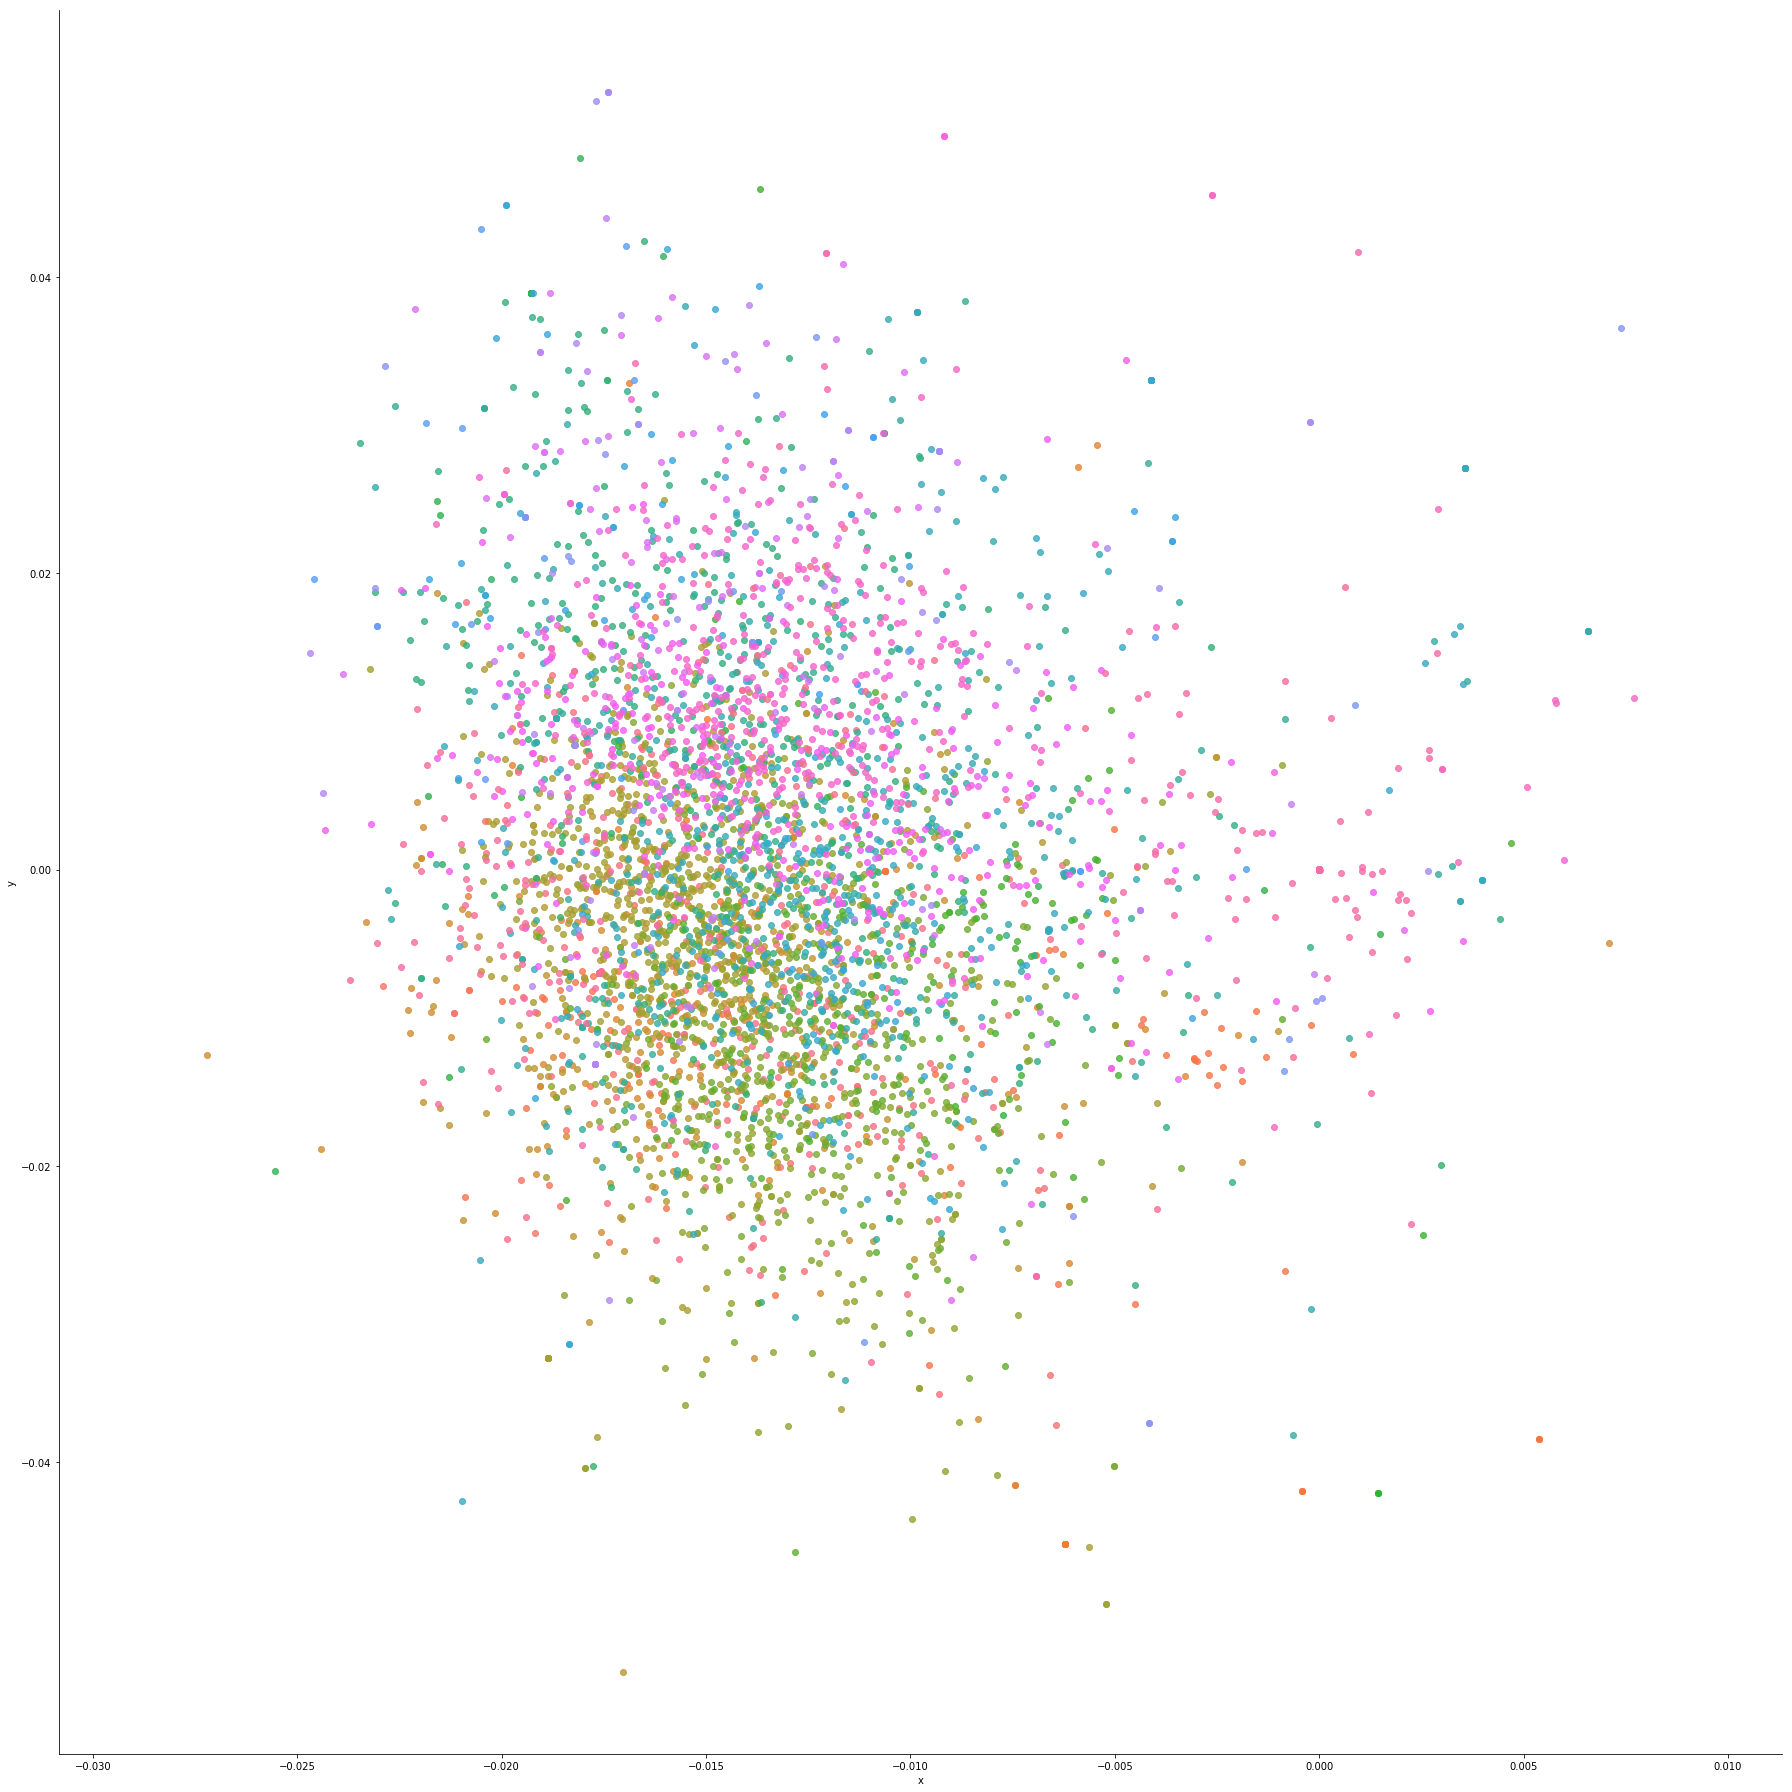

In [180]:
PCA:.p.import[`sklearn.decomposition][`:PCA];
pca:PCA[`n_components pykw 2]
pca[`:fit]np[`:array]flip 5000#affinityClusterVector;

pcaRes:flip `cluster`x`y!flip clusterLabel,'flip pca[`:components_]`
seaborn[`:lmplot][pykwargs `x`y`data`fit_reg`hue`legend`size!(`x;`y;pd[`:DataFrame]pcaRes;0b;`cluster;0b;25)];
plt[`:show][];

//unused code that was meant for annotation and color schema but seaborn has a more intuitive interface
/
{data:raze flip value x[y];
    if[20<count data;:()];
    plt[`:scatter][data[;0];data[;1];pykwargs `c`edgecolors`s!(colors[y];`r;4)]}[pcaRes] each til count colors;
//for loop for labels
//cluster word by colour then plot, dont need labels, spoils the graph
/{.[plt[`:annotate];(x;pykwargs `xy`xytext`textcoords!((y;z);(0 0);"offset points"));{-2"Error due to: ",.Q.s x}]}.'pcaRes;

\

From the PCA plot, it is shown that there is some aggregration of colours in certain areas as observed from the pinkish hue in the middle with cyan hue surrounding it.
<br>And at the bottom, we have the oilve hues.

There is an obvious separation of cluster but this also shows the limitation of the affinity propagation as it return 500+ cluster while we might just observe 5 clusters.

There is a potential bottleneck in seaborn's algorithm where colours are repeated or so similar that it cannot be distinguished.

Overall the unsupervised clustering methods are not returning the best of scatter plot with obvious distinction but we will continue to investigate if human distinction is able to validate the cluster through the sentences

## Human validation of sentence clusters


In [200]:
clusteredData:(select 5000#text from corpus),'([] clusterLabel:clusterLabel)
show 10#clusteredRes:select text by clusterLabel from clusteredData where 30<(count;i) fby clusterLabel
-1"\n\n\n~~~~Analysis of sentence clusters~~~\n";
\c 400 400
show clusteredRes[1]
-1"\nHere we see that the sentences revolves around movement/going to places and there are multiple utilisation of numbers to grouped message style together\n";
show clusteredRes[90]
-1"\nHere we see that the sentences have a vaugely similar topic which revolves around time, and appointment which suggest some useful formation of a topic\n";
\c 200 200

clusterLabel| text                                                                                                                                                                                   ..
------------| ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..
1           | ("We can go 4 e normal pilates after our intro...";"K.. I yan jiu liao... Sat we can go 4 bugis vill one frm 10 to 3 den hop to parco 4 nb. Sun can go cine frm 1030 to 2, den hop to o..
2           | ("Aiyo... U always c our ex one... I dunno abt mei, she haven reply... First time u reply so fast... Y so lucky not workin huh, got bao by ur sugardad ah...gee..";"Dunno lei he neva s..
3           | ("Oh oh... Wasted... Den muz chiong on sat n sun liao...";"Oh oh... Den muz change plan liao... Go back have to yan jiu again...";"Oh... Haha... Den we shld had went today too... Gee,..


## Conclusion
Given the freeform analysis of this notebook, there are much to explore and most exploration were just touch and go but overall there are a couple of interesting finding as concluded below:

    1. Word2Vec - skipgram is pretty intuitive in creating the distance matrix which also signifies similarity, though some words do not make sense why they are similar
    2. With the similarity we are able to create sentence vector by averaging the matrix for each word in the sentence
    3. With sentence vector, a further unsupervised learning was applied to cluster each sentence into clusters with affinity propagation
    4. The beauty of affinity propagation is that we do not have to specify the k-cluster seen in k-means, and this is useful for exploratory study
    5. However due to the exploratory nature of the algo with unrestraints, it returned 500+ cluster for 5000 words
    6. Also affinity propagation is an memory expensive algorithm implemented in sklearn, as much as it is basic, it does not allow batch processing and we had to cut our sentences sample from 50k to 5k. (4gb environment)
    7. Despite the overly exploratory use of affinity cluster, we were still able to return with humanly aggreeable results with huge cluster, but that is also due to the potentially strong output from W2V
    8. Graphing through pca and tsne proved to be time consuming and challenging as the data set is huge so for tsne, it is computationally expensive while for pca, it loses too much information to be useful.
    9. Visualisation of the cluster was a good idea but very restricted when distance are not far enough while data set is huge
    
Analysing sms data is fun and arguably the most challenging exercise of all machine learning topic. As the exploratory analysis ends off here, there are new ideas for this dataset in the pipeline.

    1. Clean the data set through intense pre-processing
    2. Apply other forms of clustering techniques while specifying k-cluster now that we know how many cluster affinity propagation returned us (we can use .nlp.cluster)
    3. Categorise each sentence to create a supervised learning model in predicting sentences category -> sentence -> vector -> model -> category
    4. Application of categorizing sms data is scary in the real world as this might offer watchdog agency on the messages being sent out and potentially classifying for dangerous activity.
    